In [1]:
using Flux, Plots
using ChainRulesCore
using Statistics
using Random
using MDToolbox
ENV["COLUMNS"] = 130

130

In [2]:
include("./tram.jl")

tram_init (generic function with 1 method)

In [3]:
?tram

search: tram tram_μ tram_init tram_R_ik tram_p_ijk tram_v_new_ik tram_f_new_ik



```
tram(c_ijk, N_ik, b_kln, index_of_cluster_kn; tol=1e-10, max_iter=20)
```

Estimates the free energy differences by transition-based reweighting analysis method (TRAM).

## Arguments

  * `c_ijk::AbstractArray`: Array containing the counts of transitions from state `i` to state `j` in ensemble `k`.
  * `N_ik::AbstractArray`: Array containing the counts of samples in state `i` in ensemble `k`.
  * `b_kln::AbstractArray`: Array of bias factors of state `k` evaluated at state `l`.
  * `index_of_cluster_kn::AbstractArray`: Array fo index of the state to which the nth sample of ensemble `k` belongs..

## Optional Arguments

  * `tol::Real = 1e-10`: Tolerance value for convergence criteria.
  * `max_iter::Integer = 20`: Maximum number of iterations allowed.


In [4]:
function compute_energy(coords1, coords2, epsilon, sigma)
    r = sqrt(sum((coords1 .- coords2).^2))
    U = epsilon * ((sigma/r)^12 - 2 * (sigma/r)^6)
    return U
end

compute_energy (generic function with 1 method)

In [5]:
function ChainRulesCore.rrule(::typeof(compute_energy), coords1, coords2, epsilon, sigma)
    dx = coords1 .- coords2
    r = sqrt(sum(dx.^2))
    U = epsilon * ((sigma / r)^12 - 2 * (sigma / r)^6) 

    function compute_energy_pullback(dU)
        dcoords1 = -12 * epsilon * ((sigma^12 / r^14) - (sigma^6 / r^8)) .* dx .* dU
        dcoords2 = - dcoords1
        depsilon = ((sigma / r)^12 - 2 * (sigma / r)^6) * dU
        dsigma = 12 * epsilon * (sigma^11 / r^12 - sigma^5 / r^6) * dU 
        return NoTangent(), dcoords1, dcoords2, depsilon, dsigma
    end
    return U, compute_energy_pullback
end

In [6]:
function _compute_distance(coords1, coords2)
    r = sqrt(sum((coords1 .- coords2).^2))
    return r
end

_compute_distance (generic function with 1 method)

## MCMC

In [7]:
#次のステップ候補点
function next_coords(coords1, coords2, delta_x = 1e-2)
    next_coords1 = coords1 .+ (rand(3) .- 0.5) .* delta_x
    next_coords2 = coords2 .+ (rand(3) .- 0.5) .* delta_x
    return next_coords1, next_coords2
end

#MCMC,メトロポリス法
function mcmc(coords1, coords2, epsilon, sigma, nstep = 100, beta = 1.0)
    coords1_trj = []
    coords2_trj = []
    alpha_trj = []
    push!(coords1_trj, coords1)
    push!(coords2_trj, coords2)
    
    for i in 1:nstep
        next_coords1, next_coords2 = next_coords(coords1, coords2) #候補点
        delta_U = compute_energy(next_coords1, next_coords2, epsilon, sigma) - compute_energy(coords1, coords2, epsilon, sigma)
        alpha = exp(-beta * delta_U) #相対確率
        
        #alpha>=1またはalpha<1のとき確率alphaで候補を受理
        if alpha >= rand()
            coords1 .= next_coords1
            coords2 .= next_coords2
        end     
        push!(coords1_trj, copy(coords1))
        push!(coords2_trj, copy(coords2))
        push!(alpha_trj, alpha)
    end
    
    coords1_trj = transform_matrix(hcat(coords1_trj...))
    coords2_trj = transform_matrix(hcat(coords2_trj...))
    
    return coords1_trj, coords2_trj, alpha_trj
end

function transform_matrix(matrix)
    rows, cols = size(matrix)
    transformed_matrix = [matrix[j, i] for i in 1:cols, j in 1:rows]
    return transformed_matrix
end

transform_matrix (generic function with 1 method)

In [74]:
K = 3

epsilon = Vector{Float64}(undef, K)
sigma = Vector{Float64}(undef, K)

epsilon[1] = 1.0
sigma[1] = 2.0

epsilon[2] = 1.01
sigma[2] = 2.01

epsilon[3] = 1.02
sigma[3] = 2.02

kBT = 2.0
beta = 1.0/(kBT)
nstep = 1000000

#seed_value = 123 #乱数固定
#Random.seed!(seed_value)

trj1_k = Vector{Any}(undef, K)
trj2_k = Vector{Any}(undef, K)
for k = 1:K
    coords = ([0.0, 0.0, 0.0], [sigma[k], 0.0, 0.0]) #初期座標
    trj1_k[k], trj2_k[k], alpha = mcmc(coords[1], coords[2], epsilon[k], sigma[k], nstep, beta)
end

In [75]:
u_kl = Array{Array{Float64}}(undef, (K, K))
for k in 1:K
    for l in 1:K
        u_kl[k, l] = map(i -> beta * compute_energy(trj1_k[k][i, :], trj2_k[k][i, :], epsilon[l], sigma[l]), 1:nstep)
    end
end

distance_k = Vector{Vector{Float64}}(undef, K)
for k in 1:K
    distance_k[k] = zeros(Float64, nstep)
    for i in 1:nstep
        distance_k[k][i] = _compute_distance(trj1_k[k][i, :], trj2_k[k][i, :])
    end
end

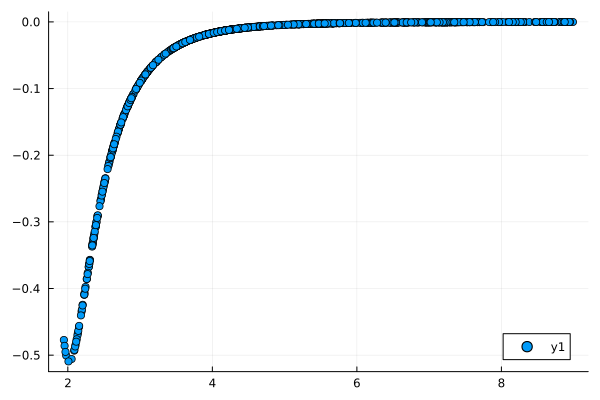

In [78]:
kstate = 3

scatter(distance_k[kstate][1:1000:end], u_kl[kstate, kstate][1:1000:end])

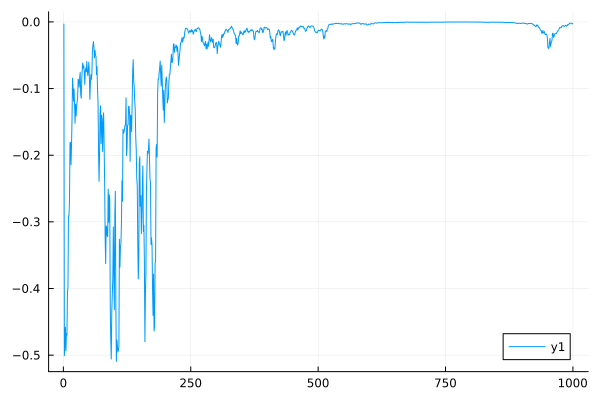

In [79]:
plot(u_kl[kstate, kstate][1:1000:end])

## MSM

In [80]:
ncluster = 2
tau = 10

K = 3
m = ncluster

c_ijk = zeros(Int64, m, m, K)
N_ik = zeros(Int64, m, K)

X = vcat(distance_k...)
X = reshape(X, length(X), 1)
#F = clusterkcenters(X ,ncluster)
F = clusterkmeans(X, m)

index_of_cluster_kn = zeros(Int64, K, length(distance_k[1]))
center_of_cluster = F.center

istart = 1
for k in 1:length(distance_k)
    iend = istart + length(distance_k[k]) - 1
    c_ijk[:, :, k] = msmcountmatrix(F.indexOfCluster[istart:iend], tau=tau)
    for i in 1:ncluster
        N_ik[i, k] = count(x -> x == i, F.indexOfCluster[istart:iend])
    end
    index_of_cluster_kn[k, :] = F.indexOfCluster[istart:iend]
    istart = iend + 1
end

In [81]:
N_k = Array{Int}(undef, K)
for k in 1:K
    N_k[k] = length(distance_k[k])
end
u_kln = zeros(Float64, K, K, maximum(N_k))
for k in 1:K
    for l in 1:K
        u_kln[k, l, 1:N_k[k]] .= u_kl[k, l]
    end
end

In [82]:
f_ik, v_ik, R_ik = tram(c_ijk, N_ik, u_kln, index_of_cluster_kn, tol=1e-10, max_iter=100)

iteration = 1, delta = 0.4314833611495924
iteration = 2, delta = 0.0005117289309595208
iteration = 3, delta = 0.00047836921790089804
iteration = 4, delta = 0.0004778163754655118
iteration = 5, delta = 0.0004772794605263364
iteration = 6, delta = 0.0004767430568759501
iteration = 7, delta = 0.0004762071569175408
iteration = 8, delta = 0.00047567176063290084
iteration = 9, delta = 0.00047513686799716126
iteration = 10, delta = 0.0004746024789945569
iteration = 11, delta = 0.000474068593596888
iteration = 12, delta = 0.00047353521178084
iteration = 13, delta = 0.0004730023335213218
iteration = 14, delta = 0.00047246995878968967


LoadError: InterruptException:

In [51]:
mbar_f_k = mbar(u_kl)

iteration = 1  delta = 1.998419e+00  tol = 1.000000e-08
free energies =  0.000000 -0.013897 -0.026002

iteration = 2  delta = 8.967628e-03  tol = 1.000000e-08
free energies =  0.000000 -0.013958 -0.026120

iteration = 3  delta = 4.020117e-05  tol = 1.000000e-08
free energies =  0.000000 -0.013958 -0.026120

iteration = 4  delta = 1.802136e-07  tol = 1.000000e-08
free energies =  0.000000 -0.013958 -0.026120

iteration = 5  delta = 8.079720e-10  tol = 1.000000e-08
free energies =  0.000000 -0.013958 -0.026120

iteration = 6  delta = 3.533603e-12  tol = 1.000000e-08
free energies =  0.000000 -0.013958 -0.026120

iteration = 7  delta = 1.359078e-13  tol = 1.000000e-08
free energies =  0.000000 -0.013958 -0.026120

iteration = 8  delta = 0.000000e+00  tol = 1.000000e-08
free energies =  0.000000 -0.013958 -0.026120

iteration = 9  delta = 0.000000e+00  tol = 1.000000e-08
free energies =  0.000000 -0.013958 -0.026120

iteration = 10  delta = 0.000000e+00  tol = 1.000000e-08
free energies = 

3-element Vector{Float64}:
  0.0
 -0.013957860724872378
 -0.026120046750843878

In [83]:
p_ijk = tram_p_ijk(c_ijk, v_ik, f_ik)

2×2×3 Array{Float64, 3}:
[:, :, 1] =
 2.44455      0.000684823
 0.000435531  0.372019

[:, :, 2] =
 1.13719     0.000298469
 0.00136541  0.568716

[:, :, 3] =
 15.211        0.00552317
  0.000316877  0.425449

In [65]:
# m=1以外の場合でも全部ゼロになるためpの計算式はあってそう
for k in 1:K
    for i in 1:m
        for j in 1:m
            println(exp(-f_ik[i, k]) * p_ijk[i, j, k] - exp(-f_ik[j, k]) * p_ijk[j, i, k])
        end
    end
end

0.0
0.0
0.0
0.0
0.0
1.0842021724855044e-19
-1.0842021724855044e-19
0.0
0.0
0.0
0.0
0.0


In [84]:
# tram

for k in 1:K
    for i in 1:m
        a = 0
        for j in 1:K
            for n in 1:N_k[j]
                if(index_of_cluster_kn[j, n] == i)
                    bunsi = 0
                    bunbo = 0
                    bunsi = exp(f_ik[i, k] - u_kln[j, k, n])
                    #=
                    for l in 1:K
                        bunbo += R_ik[1, l] * exp(f_ik[1, l] - u_kln[l, j, n])
                    end
                    =#
                    logbunbo = MDToolbox.logsumexp(log.(R_ik[i, :]) + f_ik[i, :] -u_kln[j, :, n])
                    bunbo = exp(logbunbo)
                    a += bunsi / bunbo
                end
            end
        end
        println("kstate = $(k) istate = $(i) a = $(a)")
    end
end

kstate = 1 istate = 1 a = 2.410578965511886
kstate = 1 istate = 2 a = 0.39069439258788585
kstate = 2 istate = 1 a = 0.9645644669669233
kstate = 2 istate = 2 a = 1.1218900128693254
kstate = 3 istate = 1 a = 18.805906168386453
kstate = 3 istate = 2 a = 0.27365160824455964


In [41]:
# mbar
for k in 1:K   
    a = 0
    for j in 1:K
        for n in 1:N_k[j]
            bunsi = 0
            bunbo = 0
            bunsi = exp(mbar_f_k[k] - u_kln[j, k, n])
            #=
            for l in 1:K
                bunbo += N_k[l] * exp(mbar_f_k[l] - u_kln[j, l, n])
            end
            =#
            logbunbo = MDToolbox.logsumexp(log.(N_k[:]) + mbar_f_k[:] - u_kln[j, :, n])
            bunbo = exp(logbunbo)
            a += bunsi / bunbo
        end
    end
    println("kstate = $(k) a = $(a)")
end

kstate = 1 a = 1.0000000000000722
kstate = 2 a = 1.0000000000000124
kstate = 3 a = 0.9999999999999871


In [45]:
# tram
f_ik

1×3 Matrix{Float64}:
 0.0  -0.00266957  -0.0330889

In [46]:
# mbar
mbar_f_k

3-element Vector{Float64}:
  0.0
 -0.013957860724872378
 -0.026120046750843878

## To do
- mbarとTRAMの計算結果の整合性が取れない原因を突き止める
- R_ikやv_ikは間違ってなさそう
- f_ikの計算が違う？そもそもfの定義が違う？
- u_klnの確認をしっかりした方が良さそう
- mが2以上のとき計算結果がバグる、おそらくfの正規化かfの更新アルゴリズムのどちらかがバグってる気がする
- i,j,kの添字があっているか確認した方が良さそう
- tram方程式のfの方とvの方どっちも一度コーディングして、計算結果の整合性が取れているかの確認を早くできるようにする